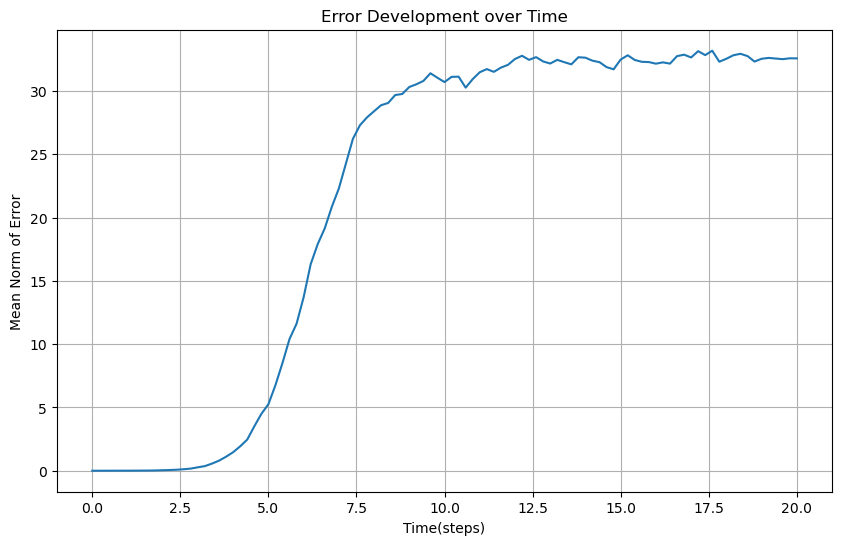

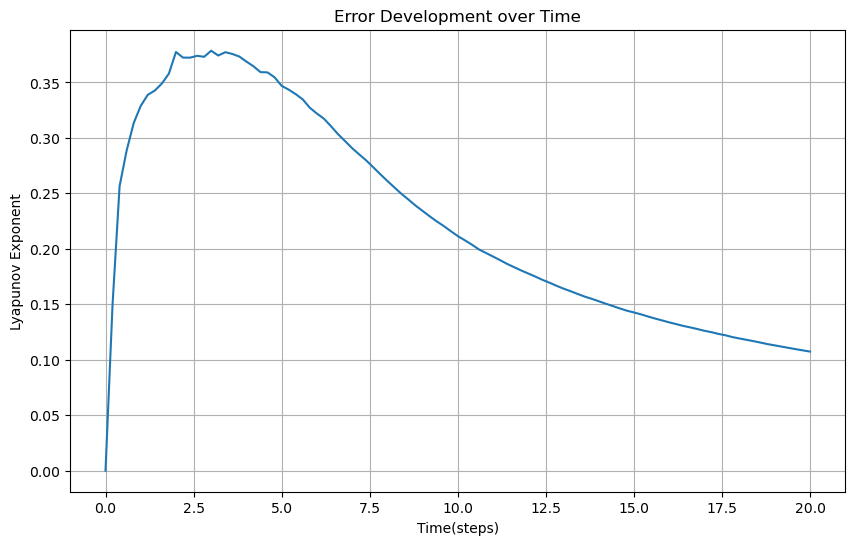

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#Fは外力項
F = 8.0
#Nは解析データの次元
N = 40 #40変数モデル
#サンプル数(正規分布だから30でいい？)
sample = 50
#ステップ時間(1日)
dt = 0.2
#摂動
epsilon = 1e-4
#誤差の時間発展評価の終点
tend_attract = 20

def L96(t,x,F):
    dxdt = np.zeros((N))
    for i in range(2, N-1):
        dxdt[i] = (x[i+1]-x[i-2])*x[i-1] - x[i] + F

    dxdt[0] = (x[1]-x[N-2])*x[N-1] - x[0] + F
    dxdt[1] = (x[2]-x[N-1])*x[0] - x[1] + F
    dxdt[N-1] = (x[0]-x[N-3])*x[N-2] - x[N-1] + F

    return dxdt

#初期条件
X = F + np.random.randn(N)
#十分長い時間(前半半分はアトラクター乗ってないとして切り捨てる)
tspan = (0.0 , 100)
t_eval = np.linspace(tspan[0], tspan[1], int(tspan[1] * int(1 / dt) + 1))
#ODEの解法
sol = solve_ivp(L96, tspan, X, args=(F,), method='RK45', t_eval=t_eval)
#誤差評価用の配列
error = np.zeros((sample, int(tend_attract * int(1 / dt) + 1)))

for i in range(sample):
    #attoractorにはいつから乗るかわからないので半数切り捨てた
    #sol.yは N * len(t_eval) の形
    X_attract = sol.y[:, int(len(t_eval) / 2) + int(1 / dt) * i] 
    #少しずらす
    X_attract_perturb = X_attract + epsilon * np.random.randn(N)
    #摂動を加えた初期条件での積分
    #dense_output=Trueを設定すると、返される解のオブジェクトから、任意の時間点での状態を計算するための補間関数を生成するできる。
    #これにより、t_evalで指定された離散的な時間点以外の時刻における解も求めることが可能。
    sol_attract = solve_ivp(L96, (0, tend_attract), X_attract, args=(F,), method='RK45', dense_output=True)
    sol_attract_perturb = solve_ivp(L96, (0, tend_attract), X_attract_perturb, args=(F,), method='RK45', dense_output=True)
    #誤差の時間発展間隔
    tspan_attract = np.linspace(0.0, tend_attract, int(tend_attract * int(1 / dt) + 1))
    attract = sol_attract.sol(tspan_attract)#補間関数('sol')
    attract_perturb = sol_attract_perturb.sol(tspan_attract)
    # 時間ごとのノルムの差
    for j in range(len(tspan_attract)):
        error[i, j] = np.linalg.norm(attract[:, j] - attract_perturb[:, j])
# エラーの平均を計算
error_mean = np.mean(error, axis=0)
#誤差評価用の配列(リアプノフ指数)
error_lyapunov = np.zeros(len(error_mean))
for i in range(len(error_mean)):
    error_lyapunov[i] = np.log(abs(error_mean[i] / error_mean[0])) / (i + 1)

# 結果のプロット
plt.figure(figsize=(10, 6))
plt.plot(tspan_attract, error_mean, label='Mean Error')
plt.xlabel('Time(steps)')
plt.ylabel('Mean Norm of Error')
plt.title('Error Development over Time')
plt.grid()
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(tspan_attract, error_lyapunov, label='Mean Error')
plt.xlabel('Time(steps)')
plt.ylabel('Lyapunov Exponent')
plt.title('Error Development over Time')
plt.grid()
plt.show()